In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from pyslabgrid import slabgridding as slg
from pyslabgrid import mat as mat
from pyslabgrid import reckoner as reck

In [2]:
def get_finterp(lon, lat, dep, param):
    slon, slat, spar = ([],[],[])
    
    for i in range(len(dep)):
        if (param[i]<0) | np.isnan(param[i]):
            continue
        else:
            slon.append(float(lon[i]))
            slat.append(float(lat[i]))
            spar.append(float(param[i]))

    y = np.transpose([slon, slat])
    fintp = RBFInterpolator(y, np.array(spar), smoothing=0, kernel='linear')  
    return(fintp)

def get_3sheets(X,Y,Z, szone, depdistr = None):
    # orthogal shifted sheets
    if depdistr is None:
        depdistr = {'hik': [[17, 29, 40]], 'puy': [[10,15,20]], }

    deps = depdistr[szone][0]
    
    X1, Y1, Z1 = reck.shiftsheet(szone, deps[0], (X,Y,Z))
    X2, Y2, Z2 = reck.shiftsheet(szone, deps[1], (X,Y,Z))
    X3, Y3, Z3 = reck.shiftsheet(szone, deps[2], (X,Y,Z))
    
    sheets = {'interface': [X,Y,Z],
              'slabq1': [X1,Y1,Z1], 
              'slabq2': [X2,Y2,Z2], 
              'slabq3': [X3,Y3,Z3],}
        
    return sheets

def get_sheet_interpolator(szone, depdistr=None):
    subdmod =  mat.getdict('../data/subduction_model/subduction_model.mat')
    X = mat.flatten(subdmod[szone]['lon'].tolist())
    Y = mat.flatten(subdmod[szone]['lat'].tolist())
    Z = mat.flatten(subdmod[szone]['dep'].tolist())
    
    sheets  = get_3sheets(X,Y,Z,szone, depdistr = depdistr)
    X1,Y1,Z1 =  sheets['slabq1']
    X2,Y2,Z2 =  sheets['slabq2']
    X3,Y3,Z3 =  sheets['slabq3']
 
    fintp_sheetQ1 = get_finterp(X1, Y1, Z1, Z1)
    fintp_sheetQ2 = get_finterp(X2, Y2, Z2, Z2)
    fintp_sheetQ3 = get_finterp(X3, Y3, Z3, Z3)
    finterpdict = {'sheet1':fintp_sheetQ1, 'sheet2': fintp_sheetQ2, 'sheet3': fintp_sheetQ3,}
    
    return finterpdict

In [3]:
depdistr = {'hik': [[17, 29, 40]], 'puy': [[10,15,20]],}

finterpdict_hik = get_sheet_interpolator('hik', depdistr = depdistr)
finterpdict_puy = get_sheet_interpolator('puy',depdistr = depdistr)

np.save('../pyslabgrid/finterp_slabdeps.npy', {'hik': finterpdict_hik, 'puy': finterpdict_puy})


<IPython.core.display.Javascript object>


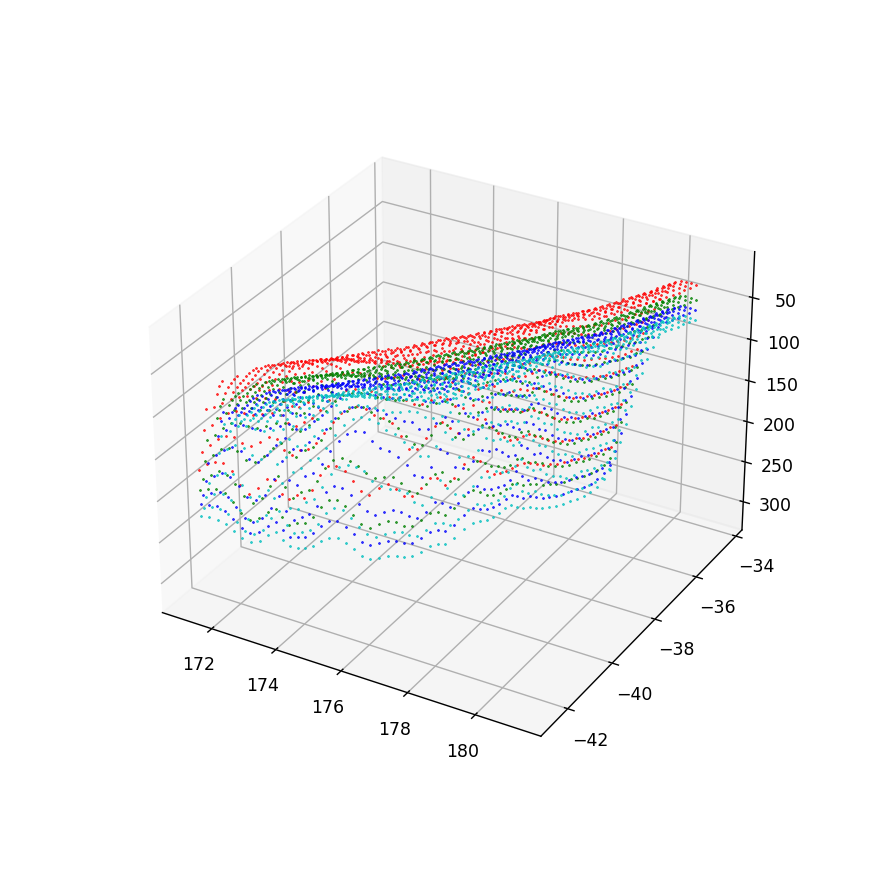

In [5]:
# test the interpolatiors
szone = 'hik'  # szone = 'puy'
hik_finterp = np.load('../pyslabgrid/finterp_slabdeps.npy', allow_pickle=True)[()]
fintp_sheet1 = hik_finterp[szone]['sheet1']
fintp_sheet2 = hik_finterp[szone]['sheet2']
fintp_sheet3 = hik_finterp[szone]['sheet3']

subdmod =  mat.getdict('../data/subduction_model/subduction_model.mat')     
xx = mat.flatten(subdmod[szone]['lon'].tolist())
yy = mat.flatten(subdmod[szone]['lat'].tolist())
zz = mat.flatten(subdmod[szone]['dep'].tolist())

X,Y,Z = [],[],[]
for x,y,z in zip(xx,yy,zz):
    if np.isnan(z):
        continue
    else:
        X.append(x)
        Y.append(y)
        Z.append(z)
Z1 = fintp_sheet1(np.transpose([X,Y])).tolist()
Z2 = fintp_sheet2(np.transpose([X,Y])).tolist()
Z3 = fintp_sheet3(np.transpose([X,Y])).tolist()

%matplotlib notebook
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7,7))
ax.plot3D(X, Y, Z,'.', markersize=1, color='r');
ax.plot3D(X, Y, Z1,'.', markersize=1, color='g');
ax.plot3D(X, Y, Z2,'.', markersize=1, color='b');
ax.plot3D(X, Y, Z3,'.', markersize=1, color='c');
ax.invert_zaxis()
